In [101]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from uavsar_pytools.snow_depth_inversion import depth_from_phase
from stats import get_stats, clean_xs_ys
from pathlib import Path
from scipy.ndimage import gaussian_filter
# ds = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Banner.sd.nc')

/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Mores.sd.nc
/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Banner.sd.nc
/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Dry_Creek.sd.nc


(0.0, 3.0)

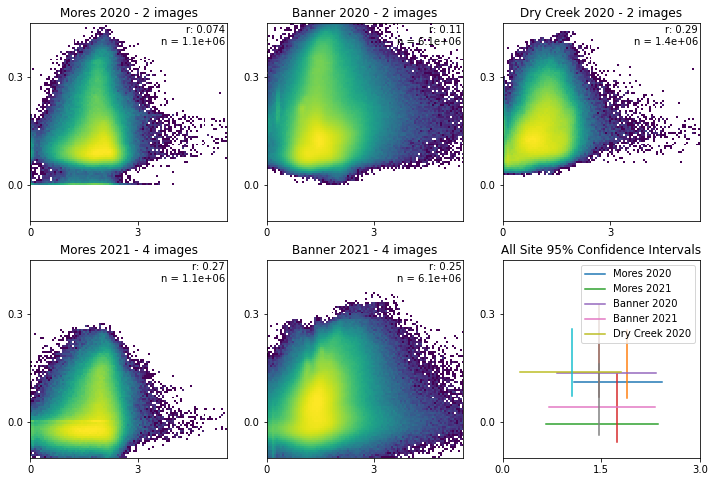

In [182]:
fig, axes = plt.subplots(2, 3, figsize = (12, 8))

for i, fp in enumerate(Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/').glob('*.sd.nc')):

    # if i != 0:
    #     continue

    print(fp)
    ds = xr.open_dataset(fp).load()
    if isinstance(ds.lidar_times, str):
        ds['lidar_times'] = [ds.lidar_times]

    for j, time in enumerate(ds.lidar_times):
        ax = axes[j, i]
        lidar = ds['lidar-sd'].sel(time = time)
        # veg = ds['lidar-vh'].sel(time = time)
        if isinstance(time, str):
            year = pd.to_datetime(time).year
        else:
            year = pd.to_datetime(time.data).year


        uavsar = ds.sel(time = ds.time.dt.year == year)
        uavsar = uavsar.isel(time = uavsar['snotel_dSWE'] > 0.01 )
        short_baseline = pd.to_timedelta(uavsar['time2'] - uavsar['time']) < '15 days'
        uavsar = uavsar.isel(time = short_baseline)
        imgs = uavsar.time.size
        uavsar = uavsar['232-sd_delta_int'].sel(band = 'VV').sum(dim = 'time')
        uavsar.data = gaussian_filter(uavsar.data, 3)

        lidar, uavsar = clean_xs_ys(lidar, uavsar, clean_zeros = True)

        uavsar = uavsar[lidar > 0]
        lidar = lidar[lidar > 0]

        rmse, r, n = get_stats(lidar, uavsar)
        x05, x99 = np.quantile(lidar, [0.001, 0.9999])
        y05, y95 = np.quantile(uavsar, [0.001, 0.9999])

        range = [[0, x99], [y05, y95]]
        range = [[0, 5.5], [-0.1, 0.45]]

        ax.hist2d(x = lidar, y = uavsar, bins = 100, norm = mpl.colors.LogNorm(), range = range)
        ax.text(.99, .99, f'r: {r:.2}\nn = {n:.1e}', ha = 'right', va = 'top', transform = ax.transAxes)
        ax.set_xlim(0, x99)
        ax.set_title(f"{fp.stem.split('.')[0].replace('_',' ')} {year} - {imgs} images")

        x05, x95 = np.quantile(lidar, [0.05, 0.95])
        y05, y95 = np.quantile(uavsar, [0.05, 0.95])

        axes[1, 2].plot([x05, x95], [np.median(uavsar), np.median(uavsar)], label = f"{fp.stem.split('.')[0].replace('_',' ')} {year}")
        axes[1, 2].plot([np.median(lidar), np.median(lidar)], [y05, y95])

for ax in axes.ravel():
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.yaxis.set_major_locator(plt.MaxNLocator(2))
    ax.set_xlim(0, 5.5)
    ax.set_ylim(-0.1, 0.45)
axes[1,2].legend()
axes[1,2].set_title('All Site 95% Confidence Intervals')
axes[1,2].set_xlim(0, 3)

/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Mores.sd.nc
/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Banner.sd.nc
/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Dry_Creek.sd.nc


Text(0.5, 1.0, 'All Site 95% Confidence Intervals')

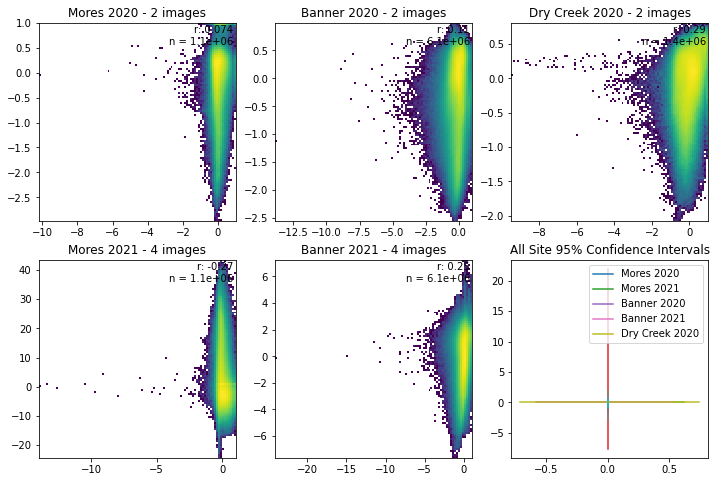

In [181]:
fig, axes = plt.subplots(2, 3, figsize = (12, 8))

for i, fp in enumerate(Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/').glob('*.sd.nc')):

    # if i != 0:
    #     continue

    print(fp)
    ds = xr.open_dataset(fp).load()
    if isinstance(ds.lidar_times, str):
        ds['lidar_times'] = [ds.lidar_times]

    for j, time in enumerate(ds.lidar_times):
        ax = axes[j, i]
        lidar = ds['lidar-sd'].sel(time = time)
        # veg = ds['lidar-vh'].sel(time = time)
        if isinstance(time, str):
            year = pd.to_datetime(time).year
        else:
            year = pd.to_datetime(time.data).year


        uavsar = ds.sel(time = ds.time.dt.year == year)
        uavsar = uavsar.isel(time = uavsar['snotel_dSWE'] > 0.01 )
        short_baseline = pd.to_timedelta(uavsar['time2'] - uavsar['time']) < '15 days'
        uavsar = uavsar.isel(time = short_baseline)
        imgs = uavsar.time.size
        uavsar = uavsar['232-sd_delta_int'].sel(band = 'VV').sum(dim = 'time')
        uavsar.data = gaussian_filter(uavsar.data, 3)

        lidar, uavsar = clean_xs_ys(lidar, uavsar, clean_zeros = True)

        uavsar = uavsar[lidar > 0]
        lidar = lidar[lidar > 0]

        uavsar = (np.median(uavsar) - uavsar) / np.median(uavsar)
        lidar = (np.median(lidar) - lidar) / np.median(lidar)

        rmse, r, n = get_stats(lidar, uavsar)
        x05, x99 = np.quantile(lidar, [0.001, 0.9999])
        y05, y95 = np.quantile(uavsar, [0.001, 0.9999])

        range = [[x05, x99], [y05, y95]]
        # range = [[0, 5.5], [-0.1, 0.45]]

        ax.hist2d(x = lidar, y = uavsar, bins = 100, norm = mpl.colors.LogNorm()) # range = range
        ax.text(.99, .99, f'r: {r:.2}\nn = {n:.1e}', ha = 'right', va = 'top', transform = ax.transAxes)
        # ax.set_xlim(0, x99)
        ax.set_title(f"{fp.stem.split('.')[0].replace('_',' ')} {year} - {imgs} images")

        x05, x95 = np.quantile(lidar, [0.05, 0.95])
        y05, y95 = np.quantile(uavsar, [0.05, 0.95])
        # axes[1, 2].errorbar(np.median(lidar), np.median(uavsar), xerr = np.array([x05, x99]).reshape(2, 1), yerr = np.array([y05, y95]).reshape(2, 1), label = f"{fp.stem.split('.')[0].replace('_',' ')} {year}")
        axes[1, 2].plot([x05, x95], [np.median(uavsar), np.median(uavsar)], label = f"{fp.stem.split('.')[0].replace('_',' ')} {year}")
        axes[1, 2].plot([np.median(lidar), np.median(lidar)], [y05, y95])

# for ax in axes.ravel():
    # ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    # ax.yaxis.set_major_locator(plt.MaxNLocator(2))
    # ax.set_xlim(0, 5.5)
    # ax.set_ylim(-0.1, 0.45)
axes[1,2].legend()
axes[1,2].set_title('All Site 95% Confidence Intervals')
# axes[1,2].set_xlim(0, 3)